In [1]:
# 라이브러리 호출
import bok_da as bd
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

#### 본 사용자 매뉴얼에서는 구조 VAR 모형에 대한 내용을 다룬다.
- 구조충격 식별
- 충격반응함수 도출

## 1. 데이터 불러오기
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

데이터는 한국의 전기대비 실질 GDP 성장률, CD91일 금리, 인플레이션율 소비자 가격 지수 (Consumer Price Index, CPI), CD91일 금리로 1999년 4분기부터 2023년 4분끼지의 분기별 자료이다. 해당 데이터는 ECOS (https://ecos.bok.or.kr/#/)에서 다운로드 받았으며 컴퓨터에 "python_data.xlsx"라는 이름의 엑셀파일의 "KORmacro"라는 시트에 저장되어 있다. 이때, 인플레이션율의 경우 소비자 가격 지수 (Consumer Price Index, CPI)의 전년동기대비 치분 (YoY)을 통해 미리 변환한 것이다.

`data` 폴더에서 `python_data.xlsx`를 불러온 후 파이썬 표준 자료형인 `pandas.DataFrame`으로 전처리를 수행한다. `DataFrame`은 테이블 형태의 데이터의 행(날짜)과 열(변수명) 정보를 가지고 있어, 행렬이나 벡터형태로 분석하는 것보다 유용하다. `df`라는 이름으로 할당하는 것이 일반적이다. 데이터프레임에 익숙하지 않은 경우 아래 셀의 코드를 줄별로 여러 셀로 나누어 실행해보는 것을 추천한다. 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [3]:
df = pd.read_excel('../data/python_data.xlsx', sheet_name='KORmacro') # 데이터 엑셀파일 불러오기
df = df.set_index('date', inplace=False) # date 명의 열을 인덱스로 지정한다.
df.index.name = None # 인덱스 이름 date를 제거한다.
df.index = df.index.str.replace('/', '-') # 2000/03 형식을 pandas가 날짜로 인식하도록 2000-3형식으로 변환한다.
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0) # 인덱스(행)를 날짜로 인식하도록 변환한다.
df.index.freq = pd.offsets.QuarterEnd() # 인덱스의 frequency를 분기말(2000-03-31)로 설정한다.
column_order = ['inf', 'rgdp', 'cd91'] # df의 열 순서를 리스트로 미리 할당
df = df[column_order] # df의 열 순서를 column_order에 맞게 변경
df

,inf,rgdp,cd91
2000-12-31,2.508257,-0.3,6.97
2001-03-31,3.627876,1.2,5.95
2001-06-30,4.919778,1.3,5.78
2001-09-30,4.158456,1.4,4.97
2001-12-31,3.244327,1.8,4.58
...,...,...,...
2022-12-31,5.083054,-0.3,3.91
2023-03-31,4.496285,0.3,3.64
2023-06-30,3.212650,0.6,3.63
2023-09-30,3.079117,0.6,3.74


## 2. 구조 VAR 모형의 충격 반응 함수 도출

`bok_da` 라이브러리 시계열분석 패키지(`ts`)의 VAR모형 서브패키지(`var`)에 있는 `var_irf_bootstrap`함수를 사용하면 축약형 VAR모형 추정, 충격반응함수 및 부트스트래핑을 통한 충격반응함수의 신뢰구간을 도출할 수 있다. 충격반응함수 추정에 대한 자세한 내용은 매뉴얼 제일 아래 셀의 `(참고)`를 참조.

### (예시: 단기제약을 통한 구조형 VAR 모형의 식별)
위에서 불러온 df를 사용하여 다음과 같이 VAR(p) 모형의 충격반응함수와 신뢰구간을 추정할 수 있다. 이때, BIC로 추정한 VAR(p) 모형의 최적 시차는 `p.bic`=2이고, 충격반응함수 추정을 위해 총 16기 이후까지를 예측한다고 하자. 나아가 구조형 VAR 모형을 식별하기 위해 단기제약을 사용하고, 부트스트래핑으로 충격반응함수의 90\% 신뢰구간을, 총 2000번의 반복으로 추정한다고 하자.

In [4]:
from bok_da.ts.var import var_irf_bootstrap, order_var

In [5]:
p = order_var(df, lag_max=4)

`var_irf_bootstrap` 함수는 `data`(데이터), `lag`(시차), `h`(충격반응함수 기간), `irf`(식별 방법), `q`(quantile), `n`(부트스트랩 횟수)을 인자로 갖는다. 이 중 `data`를 제외한 모든 인자는 기본값(default)을 갖는다.(lag=None, h=16, irf='short', q=90, n=2000). 다음 셀과 같이 df만 입력하는 경우 나머지 인자는 기본값을 기준으로 추정된다.

In [6]:
res = var_irf_bootstrap(df) # by default: lag=1, h=16, irf='short', q=90, n=2000

인자 값을 변경하고 싶은 경우, 직접 인자를 입력하면 된다.

In [7]:
res = var_irf_bootstrap(df, lag=p.bic, h=16, irf='short')

참고로, 동일한 분석을 `VectorAutoRegression` 클래스를 이용해서도 수행할 수 있다. `var` 서브패키지에서 `VectorAutoRegression` 클래스를 `VAR`로 불러와 사용한다.

In [8]:
from bok_da.ts.var import VectorAutoRegression as VAR

`VAR` 클래스를 이용해 `model`을 설정하고, `fit` 메서드를 이용해 추정한다. `irf=None`이거나 인자를 입력하지 않는 경우, 축약형 VAR(p) 모형 추정치를 리턴한다. irf를 'short' 또는 'long'으로 입력하면 모형 추정치와 충격반응함수 추정치를 리턴한다. `var_irf_bootstrap` 함수와 동일하게 인자를 직접 입력할 수 있다.

In [9]:
model = VAR(lag=p.bic)

In [10]:
res = model.fit(df, irf='short') # by default: h=16, q=90, n=2000

추정 결과 res는 다음의 결과를 포함한다. (irf=None 이거나 입력하지 않은 경우)
</br>
    `phi_hat`: 축약형 VAR(p) 모형의 계수 행렬 추정량
    </br>
    `omega_hat`: 축약형 VAR(p) 모형의 분산-공분산 행렬 추정량
    </br>
    `f_mat`: 축약형 VAR(p) 모형의 동반행렬 (Companion Matrix) 형태의 계수 행렬 추정량
    </br>
    `u_hat`: 축약형 VAR(p) 모형의 잔차
    </br>
    `y0`: 추정에 사용된 반응변수 행렬
    </br>
    `y_lag`: 추정에 사용된 설명변수 행렬
    </br>
    `y_predm`: 예측치
    </br>
    `lag`: 모형에 사용된 시차
    
(irf='short' 이거나 irf='long'인 경우 아래 결과값까지 리턴)
</br>
    `theta`: VAR(p) 모형의 충격반응함수
    </br>
    `cilv`: 충격반응함수 신뢰구간의 하한
    </br>
    `cihv`: 충격반응함수 신뢰구간의 상한
    </br>
    `cum_theta`: 추정된 VAR(p) 모형의 누적된 충격반응함수
    </br>
    `cum_cilv`: 누적충격반응함수 신뢰구간의 하한
    </br>
    `cum_cihv`: 누적충격반응함수 신뢰구간의 상한
    </br>

res의 메서드 `plot_irf`를 이용해 충격반응함수를 그릴 수 있다.

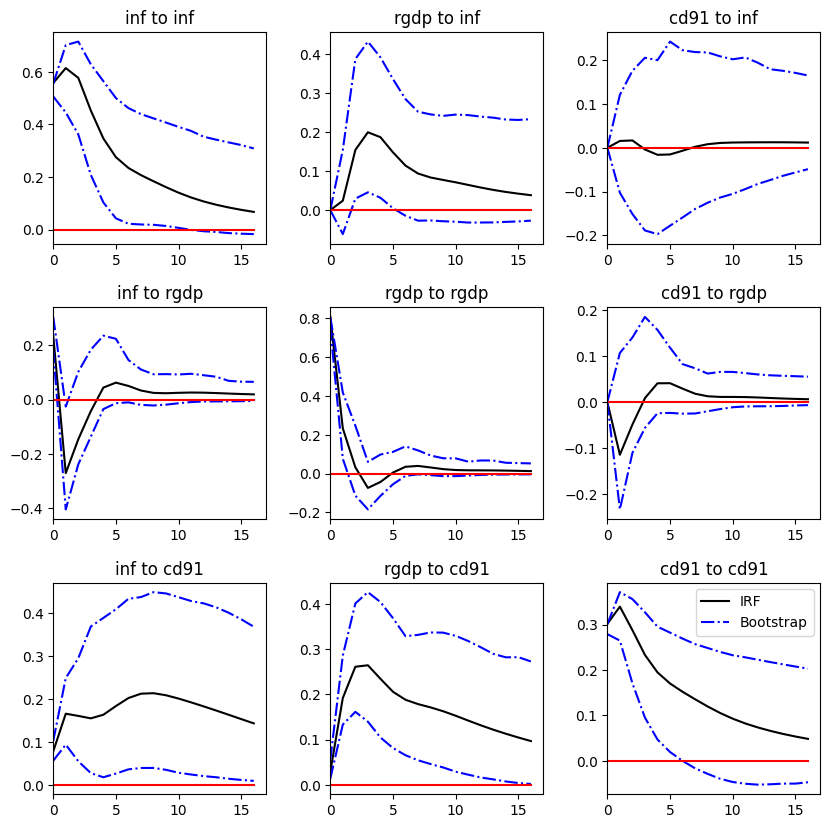

In [11]:
res.plot_irf(title=False)

누적충격반응함수는 plot_irf 메서드에 `cum=True` 옵션을 주면 된다.

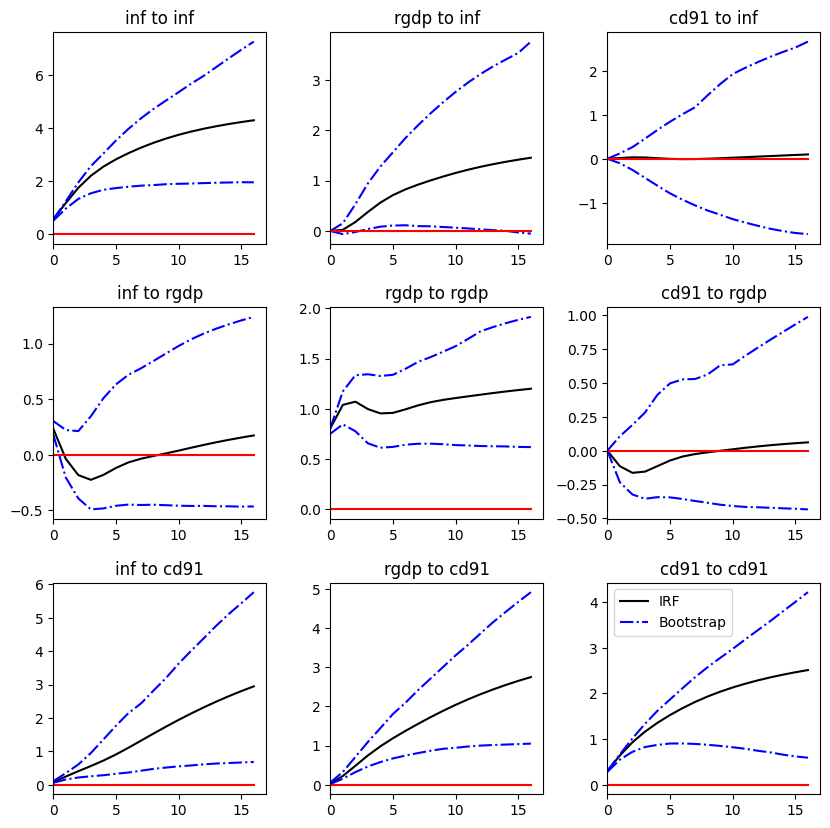

In [12]:
res.plot_irf(cum=True, title=False)

우선 검정색 실선은 충격반응함수로 식별된 3가지 구조 충격이 각 내생변수에 미치는 영향을 나타낸다. 이때, 파란색 점선은 해당 충격반응함수의 90\% 신뢰구간으로 빨간선이 신뢰구간에 포함될 경우 충격반응함수가 통계적으로 유의하지 않음을 의미한다.

위 결과에 대한 이론적인 가정은 다음과 같다. 우선 $y$ 변수를 구성하는 내생변수의 순사인
$\begin{equation}
    \begin{pmatrix}
        inflation & \Delta rgdp & interest\text{ }rate
    \end{pmatrix}^{\prime} \notag
\end{equation}$
는 다음과 같은 인과관계의 고리 (causal chain)을 가정하고 있다.
$\begin{equation}
    \begin{pmatrix}
        u_{t}^{inf} \\
        u_{t}^{\Delta rgdp} \\
        u_{t}^{int}
    \end{pmatrix} = \begin{pmatrix}
        b_{11}^{0} & 0 & 0 \\
        b_{21}^{0} & b_{22}^{0} & 0 \\
        b_{31}^{0} & b_{32}^{0} & b_{33}^{0}
    \end{pmatrix}\begin{pmatrix}
        e_{t}^{AS} \\
        e_{t}^{AD} \\
        e_{t}^{MP}
    \end{pmatrix} \tag{1}
\end{equation}$
또는
$\begin{align}
    & u_{t}^{inf} = b_{11}^{0}e_{t}^{AS} \tag{2} \\
    & u_{t}^{\Delta rgdp} = b_{21}^{0}e_{t}^{AS} + b_{22}^{0}e_{t}^{AD} \tag{3} \\
    & u_{t}^{int} = b_{31}e_{t}^{AS} + b_{32}e_{t}^{AD} + b_{33}^{0}e_{t}^{MP} \tag{4}
\end{align}$
이때, 식 (2)부터 (4)까지를 통해 구조형 VAR 모형에 다음과 같은 가정이 내포되었다는 것을 알 수 있다.
    
1. 공급 충격으로 이름 지어진 첫 번째 구조 충격이 인플레이션 (가격)과 실질 GDP 성장률 (산출량) 모두에 영향을 미치는 것은 총수요-총공급 (AD-AS) 모형에서 수평적인 AS 곡선의 이동을 가정하기 때문이다.
2. 수요 충격으로 이름 지어진 두 번째 구조 충격이 인플레이션 (가격)에만 영향을 미치는 것은 하방하는 AD 곡선의 이동을 가정하기 때문이다.
3. 외생적인 통화 정책 충격으로 이름 지어진 세 번째 구조 충격이 이자율에만 영향을 미치는 것은 공급 충격과 수요 충격에 포함되지 않는 순수한 통화 정책 충격을 가정하기 때문이다.

이러한 이론적 가정에 입각하여 각 변수에 대한 충격반응함수 이미지에 대해 다음과 같이 해석할 수 있다. 첫째로, 양의 총공급 충격은 경제 이론과 일치하게 인플레이션에 대하여 단기적인 증가와 점진적인 감소로 이어진다. 하지만, 이런 충격은 산출량의 성장률에 대해서는 통계적으로 유의하지 않지만, 단기적인 증가로 이어져 경제 이론과 모순된 결과를 보인다. 둘째로, 양의 총수요 충격은 단기적인 산출량 성장률의 증가로 이어져 AD-AS 모형의 결과와 일치하지만 그 장기적인 효과는 통계적으로 유의하지 않다. 반면, 양의 총수요 충격은 점진적인 인플레이션으로 이어지는데, 이는 통계적으로 유의하지 않을 뿐만 아니라 경제 이론과도 반대된다. 마지막으로 이자율과 관련하여 양의 총공급 충격은 경기 호황기의 이자율 증가로 이어질 가능성이, 양의 총수요 충격은 인플레이션에 대한 대응으로 이자율 증가로 이어질 가능성이 높다. 위 (3,1) 및 (3,2) 위치의 이미지를 통해 이러한 주장에 대한 실증적 근거를 제공한다. 반면, 이자율에 대한 이재아류 충격의 영향은 단기적인 증가 및 점진적인 효과 감소로 이어지는 것을 확인할 수 있다.

### (예시: 장기제약을 통한 구조 VAR 모형 식별)
한편, 이전과 같은 설정 하에서 구조 VAR 모형을 장기제약을 사용하여 식별한다고 가정하는 경우, 단기제약을 사용한 식별과는 다른 충격반응함수가 나타날 수 있다. `irf=long`이라고 바꾸고 동일한 `VAR` 클래스를 사용하였을 때의 결과는 아래와 같다.

In [13]:
model = VAR(lag=p.bic)

In [14]:
res = model.fit(df, irf='long') # by default: h=16, q=90, n=2000

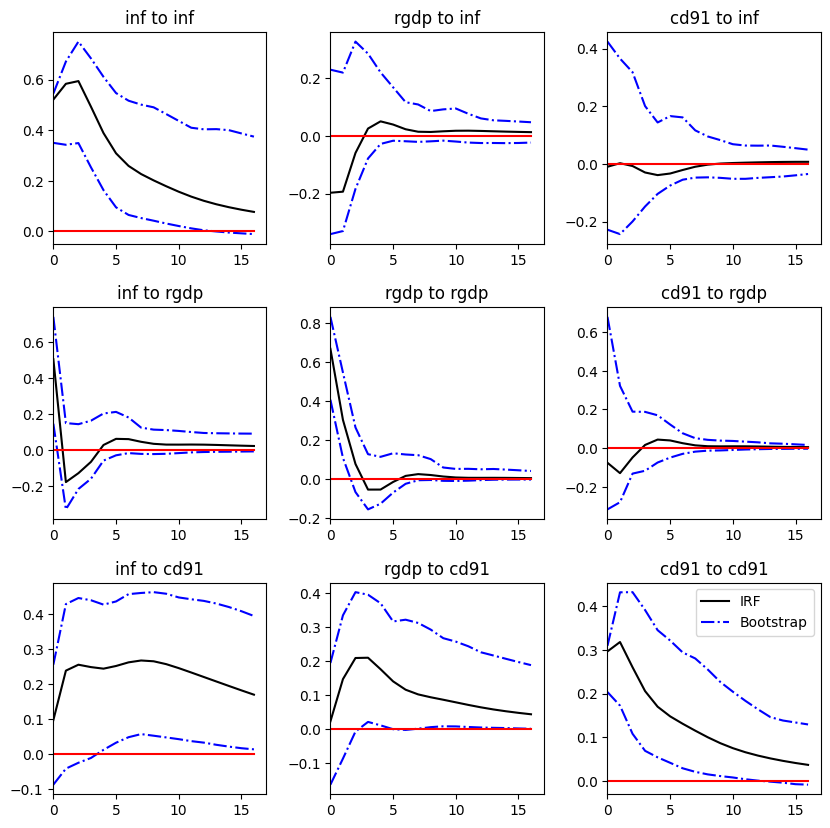

In [15]:
res.plot_irf(title=False)

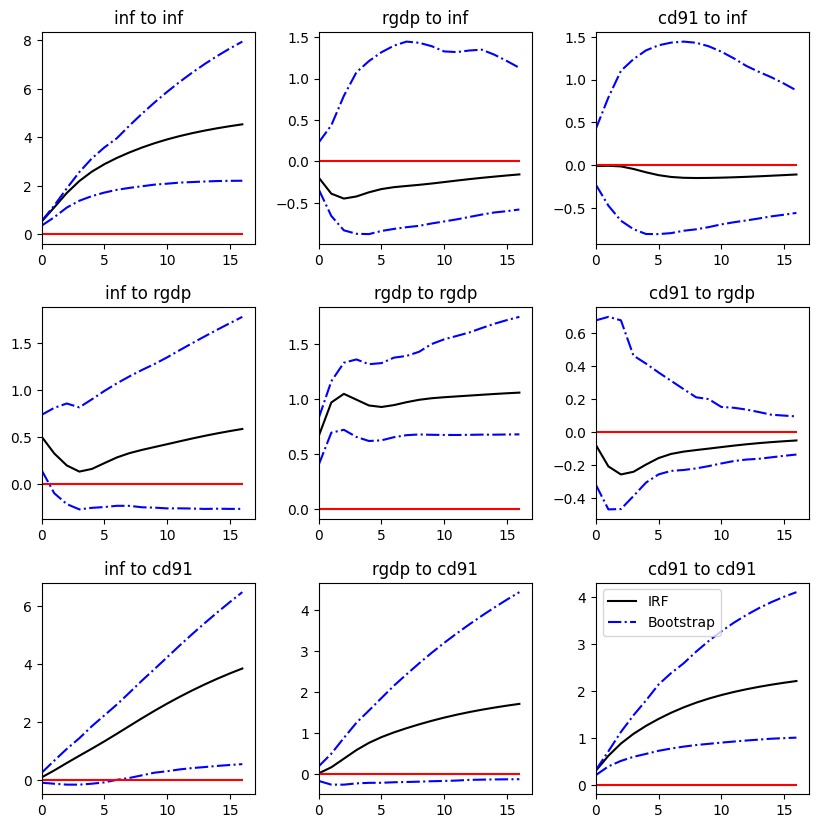

In [16]:
res.plot_irf(cum=True, title=False)

### (예시: Blanchard and Quah, 1988)
장기제약을 사용하여 구조형 VAR 모형을 식별하는 방법은 Blanchard and Quah (1989)에서 가장 먼저 제시하였다. 이를 다음과 같이 replicate 할 수 있다.

우선 bqdataset.xlsx로 저장된 데이터를 불러오자. 해당 데이터는 GNP 성장률과 실업률로 구성된다. 데이터는 1950년 2분기부터 1987년 4분기까지의 분기별 데이터를 사용하며 GNP 성장률은 전기 대비 성장률 값, 실업률은 월별 데이터의 분기별 평균값으로 구성되었다.

In [17]:
df = pd.read_excel('../data/python_data.xlsx', sheet_name='BQdata')
df = df.set_index('date')
df.index.name = None
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0)
df.index.freq = pd.offsets.QuarterEnd()
df.columns = ['gdp', 'unemp']
df

,gdp,unemp
1948-06-30,0.854440,-0.142441
1948-09-30,0.012101,-0.066165
1948-12-31,-0.085058,-0.023222
1949-03-31,-2.076586,0.786387
1949-06-30,-1.491868,1.962663
...,...,...
1986-12-31,-0.055611,-0.629303
1987-03-31,0.641805,-0.886361
1987-06-30,0.403708,-1.243419
1987-09-30,0.380276,-1.533809


논문을 그대로 replicate 하기 위해서 `lag=8`, `h=40`, 그리고 1 표준오차 밴드인 68\% 신뢰구간에 해당하는 `qt=68`을 사용한다.

In [18]:
model = VAR(lag=8)
res = model.fit(df, irf='long', h=40, q=68)

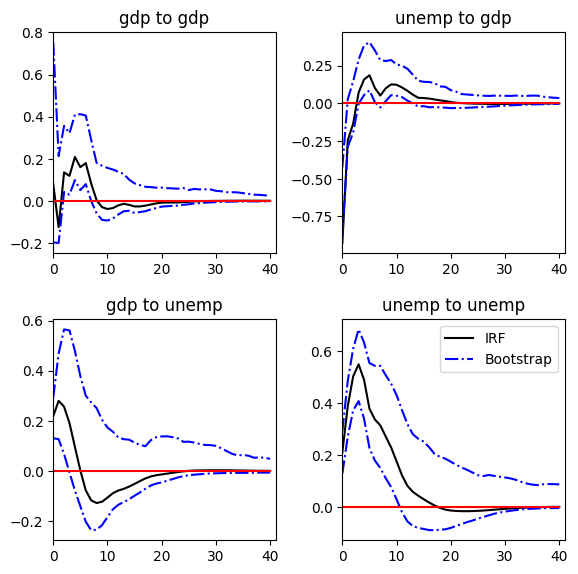

In [19]:
res.plot_irf(title=False)

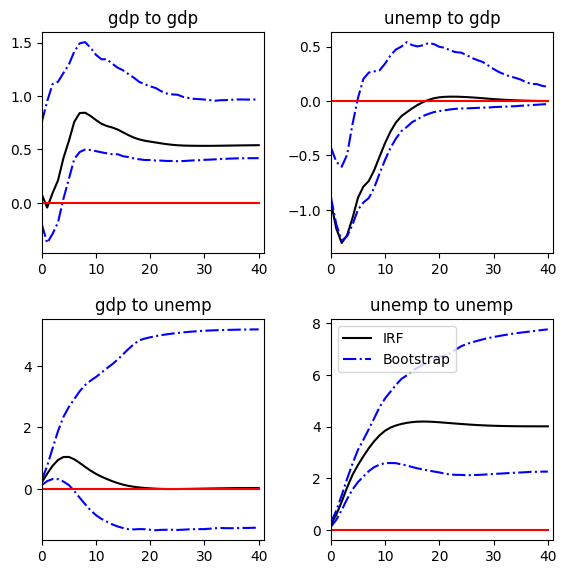

In [20]:
res.plot_irf(cum=True, title=False)

충격반응함수 중에서 첫번째는 Blanchard and Quah (1989)의 Figure 3부터 Figure 6까지의 충격반응함수와 다르다. 이는 아래와 같은 이유 때문이다.
1. 누적된 충격반응함수가 아니기 때문

우선, 두 변수 중에서 실질 GNP 성장률의 경우 차분된 값으로 누적된 충격반응함수를 도출해야한다. 이런 이유로 아래와 같이 두 변수에 대한 누적된 충격반응함수를 도출할 경우 각 구조충격이 실질 GNP 수준에 미치는 영향은 Blanchard and Quah (1989)의 Figure 4와 일치하고 Figure 3과 유사한 것을 알 수 있다.
특히, 총수요 충격인 $e_{2t}$에 대한 실질 GNP 수준에 미치는 영향의 누적된 충격반응함수는 Figure 3을 뒤집어놓은 모양인 것을 확인할 수 있다. 이는 아래의 두번째 이유와 관련이 있다.

2. 춀레스키 분해의 결과가 유일하지 않기 때문

예를 들어, 춀레스키 분해 결과 $\underline{L}$이 다음과 같이 나왔다고 하자.
$\begin{equation}
    \underline{L}\underline{L}^{\prime} = \begin{pmatrix}
    a & 0 \\
    b & c
    \end{pmatrix}\begin{pmatrix}
    a & b \\
    0 & c
    \end{pmatrix} \notag
\end{equation}$
즉, 춀레스키 분해 전의 행렬은 다음과 같다.
$\begin{equation}
    \begin{pmatrix}
        a^{2} & ab \\
        ab & b^{2}+c^{2}
    \end{pmatrix} \notag
\end{equation}$
하지만, $\underline{L}$이라는 춀레스키 분해 결과의 원소들의 부호를 다음과 같이 바꾼다면 동일한 행렬을 도출할 수 있다.
$\begin{equation}
    \begin{pmatrix}
        -a & 0 \\
        -b & c
    \end{pmatrix}\text{, }\begin{pmatrix}
        a & 0 \\
        b & -c
    \end{pmatrix}\text{, }\begin{pmatrix}
        -a & 0 \\
        -b & -c
    \end{pmatrix} \notag
\end{equation}$
이러한 이유로 춀레스키 분해 결과 도출된 $\Theta(1)$에 대한 $(2,2)$ 원소에 음수를 취한 값을 선택한다면 Blanchard and Quah (1989)와 정확히 동일한 결과를 얻을 수 있다.

#### (참고)
경제학적인 이론에 기반하여 구조형 VAR 모형의 계수들을 식별할 수 있다. 이때, 식별을 위해서는 구조형 모형과 축약형 모형의 파라미터 개수는 다음과 같다.
- 구조형 모형
$\begin{equation}
    B_{0}y_{t} = B_{1}y_{t-1} + \cdots + B_{p}y_{t-p}+e_{t}\text{, }e_{t}\sim WN(0,\Omega) \notag
\end{equation}$
따라서 $B_{0}$부터 $B_{p}$까지의 계수행렬과 대각행렬인 분산-공분산 행렬 $\Omega$에 존재하는 파라미터의 수는
$\begin{equation}
    k^{2}(p+1)+k = k^{2}p+k(k+1) \notag
\end{equation}$
이다.

- 축약형 모형
$\begin{equation}
     y_{t} = A_{1}y_{t-1} + \cdots + A_{p}y_{t-p} + u_{t}\text{, }u_{t}\sim WN(0,\Sigma) \notag
\end{equation}$
따라서 $A_{1}$부터 $A_{p}$까지의 계수행렬과 비대각 대칭행렬인 분산-공분산 행렬 $\Sigma$에 존재하는 파라미터의 수는
$\begin{equation}
    k^{2}p + \frac{k(k+1)}{2} \notag
\end{equation}$
이다.

따라서 구조형 모형은 축약형 모형에 비해 파라미터가 $k(k+1)/2$개 더 많아서 축약형 모형을 사용하여 구조형 모형을 유일하게 식별하는 것은 불가능하다. 이를 해결하기 위해 우선 구조형 모형의 분산-공분산 행렬 $\Omega$를 단위행렬로 가정하여 구조형 모형의 파라미터의 수를 $k$개 줄일 수 있다. 그 결과, 두 모형의 파라미터 수의 차이는
$\begin{equation}
    \frac{k(k+1)}{2} - k = \frac{k(k-1)}{2} \notag
\end{equation}$
개가 된다.

이후, $k(k-1)/2$개의 파라미터 숫자를 맞추기 위해서는 모형에 (1) 단기제약과 (2) 장기제약을 가하는 방법이 존재한다.

##### (1) 단기제약
구조형 충격 $e_{t}$와 축약형 충격 $u_{t}$는 다음과 같은 관계를 가지고 있다.
$\begin{align}
    \mathbb{E}(u_{t}u_{t}^{\prime}) & = \mathbb{E}(B_{0}^{-1}e_{t}e_{t}^{\prime}B_{0}^{-1}) \notag \\
    & = B_{0}^{-1}\mathbb{E}(e_{t}e_{t}^{\prime}){B_{0}^{-1}}^{\prime} \notag \\
    & = B_{0}^{-1}I_{k}{B_{0}^{-1}}^{\prime}\cdots\text{ by normalizing }\Omega \notag \\
    & = B_{0}^{-1}{B_{0}^{-1}}^{\prime} \notag \\
    & = \Sigma \notag
\end{align}$
그러면 춀레스키 분해 (Cholesky decomposition)를 통해 다음과 같은 정리가 가능하다.
> **<p style="font-size:15px">정리 1</p>**
> 어떠한 양정부호 행렬 (positive definite matrix) $\Sigma$에 대해 다음과 같은 춀레스키 분해 (Cholesky decomposition)이 가능하다.
> $\begin{equation}\Sigma=LL^{\prime}\notag\end{equation}$
> 이때, $L$은 하방 삼각행렬 (lower triangular matrix)이다.

즉,
$\begin{equation}
    B_{0}^{-1}=L\text{ 또는 }B_{0}=L^{-1} \notag
\end{equation}$
가 성립하여, 구조형 VAR 모형 식별을 위해 필요한 $k(k-1)/2$개의 제약이 대각원소의 위쪽 삼각 원소들이 0인걸로 걸리게 된다.

##### (2) 장기제약
한편, 장기제약의 경우 아래와 같이 구조형 및 축약형 VAR 모형의 장기분산 식의 관계를 사용한다.
- (i) 축약형 VAR 모형
    $\begin{align}
        & A(L)y_{t} = u_{t}\text{, }u_{t}\sim WN(0,\Sigma) \notag \\
        & \Rightarrow y_{t} = A(L)^{-1}u_{t} = \Psi(L)u_{t} \notag \\
        & \Rightarrow LongVar(y_{t}) = \Psi(1)\Sigma\Psi(1)^{\prime} \notag
    \end{align}$
- (ii) 구조형 VAR 모형
    $\begin{align}
        & B(L)y_{t} = e_{t}\text{, }e_{t}\sim WN(0,I_{k}) \notag \\
        & \Rightarrow y_{t} = B(L)^{-1}e_{t} = \Theta(L)e_{t} \notag \\
        & \Rightarrow LongVar(y_{t}) = \Theta(1)\Theta(1)^{\prime} \notag
    \end{align}$

이때,
$\begin{equation}
    \Psi(1) = A(1)^{-1} = (I_{k}-A_{1}-\cdots-A_{p})^{-1} \notag
\end{equation}$
라는 관계를 통해 축약형 VAR 모형의 계수 행렬인 $A_{1},\cdots,A_{p}$를 추정한다면 $\Psi(1)$의 추정량도 구할 수 있으며 $\Sigma$ 역시 축약형 VAR 모형으로 분산-공분산 행렬로 추정이 가능하다. 따라서 축약형 VAR 모형의 추정을 통해 $\hat{\Psi}(1)\hat{\Sigma}\hat{\Psi}(1)^{\prime}$이 도출된 상황에서 아래와 같은 관계가 성립해야한다.
$\begin{equation}
    \hat{\Psi}(1)\hat{\Sigma}\hat{\Psi}(1)^{\prime} = \Theta(1)\Theta(1)^{\prime} \notag
\end{equation}$
이후, 아래와 같은 단계를 통해 $B_{0}^{-1}$를 식별할 수 있다.
- 춀레스키 분해로 $\Theta(1)$ 추정
    $\begin{equation}
        chol(\hat{\Psi}(1)\hat{\Sigma}\hat{\Psi}(1)^{\prime})=\underline{L}\underline{L}^{\prime} = \Theta(1)\Theta(1)^{\prime} \notag
    \end{equation}$

- $B_{0}^{-1}$ 식별
    $\begin{equation}
        B_{0}^{-1}=A(1)\Theta(1) = \hat{A}(1)\underline{L} \notag
    \end{equation}$
    라는 관계를 통해 $B_{0}^{-1}$를 식별할 수 있다.

##### (3) 충격반응함수 도출
최종적으로 다음과 같은 순서에 따라 구조형 VAR 모형을 식별하고 구조 충격에 대한 충격반응함수를 도출할 수 있다.
- **<p style="font-size:15px"><Step 1>: 축약형 VAR 모형의 계수행렬 추정</p>**  
    축약형 VAR 모형의 계수 행렬의 OLS 추정량을 추정한다. 즉,
    $\begin{equation}
        Y = Z\cdot B + U \notag
    \end{equation}$
    와 같은 축약형 VAR 모형의 OLS 추정량인
    $\begin{equation}
        \hat{B} = (Z^{\prime}Z)^{-1}Z^{\prime}Y \notag
    \end{equation}$
    을 구한다.

- **<p style="font-size:15px"><Step 2>: 축양형 VAR 모형의 분산-공분산 행렬 추정</p>**  
    추정된 $\hat{B}$를 사용하여 다음과 잔차 $\hat{U}$를 도출한다.
    $\begin{equation}
        \hat{U} = Y - Z\cdot\hat{B} \notag
    \end{equation}$
    도출된 잔차를 사용해 다음과 같이 분산-공분산 행렬을 추정한다.
    $\begin{equation}
        \hat{\Sigma} = \frac{\hat{U}^{\prime}\hat{U}}{T-p\cdot K} \notag
    \end{equation}$

- **<p style="font-size:15px"><Step 3>: 추정된 축약형 VAR 모형을 동반행렬 형태로 변환한다</p>**  
    추정된 축약형 VAR 모형을 다음과 같이 동반행렬 형태로 변환한다.
    $\begin{align}
        & \begin{pmatrix}
            y_{t} \\
            y_{t-1} \\
            \vdots \\
            y_{t-p+1}
        \end{pmatrix} = \begin{pmatrix}
            A_{1} & A_{2} & \cdots & A_{p-1} & A_{p} \\
            I_{k\times(p-1)} & 0_{k\times(p-1)} & \cdots & 0 & 0 \\
            0 & I & \cdots & 0 & 0 \\
            \vdots & \vdots & \ddots & \vdots & \vdots \\
            0 & 0 & \cdots & I & 0
        \end{pmatrix}\begin{pmatrix}
            y_{t-1} \\
            y_{t-2} \\
            \vdots \\
            y_{t-p+1} \\
            y_{t-p}
        \end{pmatrix} + \begin{pmatrix}
            u_{t} \\
            0 \\
            \vdots \\
            0
        \end{pmatrix} \notag \\
        & \Rightarrow Y_{t} = \bar{A}Y_{t-1}+U_{t} \notag \\
        & \iff A(L)Y_{t} = U_{t}\text{ where }A(L)=(I-\bar{A}L) \notag
    \end{align}$
    따라서 축약형 충격 $u_{t}$에 대한 반응변수의 반응함수인 $\Psi_{j}$는 다음과 같다.
    $\begin{equation}
        \Psi_{j} = \frac{\partial y_{t}}{\partial u_{t-j}} = <1,1>\text{ block of }\bar{A}^{j} \notag
    \end{equation}$

- **<p style="font-size:15px"><Step 4>: $B_{0}^{-1}$을 식별한다</p>**  
    연구자가 원하는 식별방법 (단기 또는 장기 제약)에 따라서 $B_{0}^{-1}$을 식별한다. 대표적으로, 단기 제약을 사용할 경우 $B_{0}^{-1}$은 추정된 $\hat{\Sigma}$에 대해 다음과 같은 춀레스키 분해를 통해 식별할 수 있다.
    $\begin{equation}
        chol(\hat{\Sigma}) = \hat{B}_{0}^{-1}\cdot({\hat{B}_{0}^{-1}})^{\prime} \notag
    \end{equation}$

- **<p style="font-size:15px"><Step 5>: 충격반응함수를 도출한다</p>**  
    $B_{0}^{-1}e_{t}=u_{t}$라는 관계를 사용하여 다음과 같이 충격반응함수를 도출할 수 있다.
    $\begin{align}
        y_{t} & = \hat{\Psi(L)}\hat{u}_{t} = \hat{\Psi}(L)\hat{B}_{0}^{-1}e_{t} \notag \\
        & = (\hat{\Psi}_{0}+\hat{\Psi}_{1}L+\hat{\Psi}_{2}L^{2}+\cdots)B_{0}^{-1}e_{t} \notag \\
        & = (\hat{\Psi_{0}}\hat{B}_{0}^{-1}+\hat{\Psi}_{1}\hat{B}_{0}^{-1}L+\cdots)e_{t} \notag \\
        & = (\hat{\Theta}_{0}+\hat{\Theta}_{1}+\cdots)e_{t} \notag
    \end{align}$
    따라서 추정된 충격반응함수인 $\hat{\Theta}_{j}$는 다음과 같다.
    $\begin{equation}
        \hat{\Theta}_{j} = \hat{\Psi}_{j}\cdot\hat{B}_{0}^{-1} \notag
    \end{equation}$